# Задание

1. Провести EDA для одного из топ-50 DeFi протоколов с DeFiLlama, используя инструменты сбора данных, изученные на семинаре (*отметил свой выбор*):
    - **web3.py**
    - **Etherscan**
    - **DeFiLlama**
    - **CoinGecko**
    - **BitQuery**
2. Выбрать 1 протокол (*отметил свой выбор*):
    - **DEX**
3. Выгрузите исторические данные по метрикам протокола, его токену и рынкам. Постройте метрики и графики выбранного протокола, сравните его с конкурентами на рынке. Сделайте выводы по итогам исследования.

In [49]:
from typing import Any
from datetime import datetime
import time

import requests
import pandas as pd
import matplotlib.pyplot as plt

##  Использование *DeFiLlama*

Получим информацию о TVL.

In [23]:
def get_protocol_tvl(protocol_slug: str) -> pd.DataFrame:
    url = f"https://api.llama.fi/protocol/{protocol_slug}"
    try:
        response = requests.get(url)
        response.raise_for_status()
    except Exception as e:
        print(f"Error fetching TVL data for {protocol_slug}: {e}")
        return None

    data = response.json()
    chain = "Ethereum"

    tvl_list = data.get("chainTvls", {}).get(chain, {}).get("tvl", [])

    df = pd.DataFrame(tvl_list, columns=["date", "totalLiquidityUSD"])
    df["date"] = pd.to_datetime(df["date"], unit="s")
    return df

In [24]:
protocols = {"Uniswap": "uniswap-v3", "Sushiswap": "sushiswap", "Curve": "curve-dex"}

tvl_data = {}
for name, slug in protocols.items():
    df = get_protocol_tvl(slug)
    if df is not None:
        tvl_data[name] = df

In [28]:
tvl_data["Curve"].head()

,date,totalLiquidityUSD
0,2020-02-09,1.163733e+06
1,2020-02-10,1.372110e+06
2,2020-02-11,8.936019e+03
3,2020-02-12,3.813938e+04
4,2020-02-13,2.733316e+05


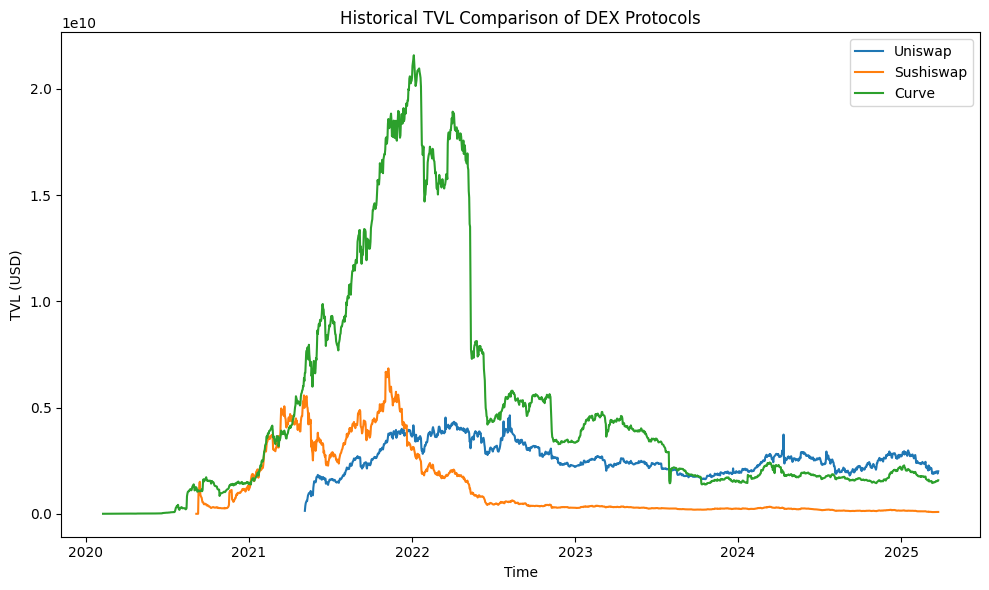

In [29]:
plt.figure(figsize=(10, 6))
for name, df in tvl_data.items():
    plt.plot(df["date"], df["totalLiquidityUSD"], label=name)

plt.xlabel("Time")
plt.ylabel("TVL (USD)")
plt.title("Historical TVL Comparison of DEX Protocols")
plt.legend()
plt.tight_layout()
plt.show()

### Выводы

- В 2020 -  2022 года Curve значительно превышал показатели Uniswap и Sushiswap, что может быть свидетельством  ориентации на ликвидность стабильных токенов. 
- Во время 'бычки' 2021 года все три протокола быстро увеличили TVL, но далее на 'медвежке' каждый из них пережил заметный спад.
-  Падение Curve с максимума было самым значительным в абсолютных числах, хотя на протяжении большей части наблюдаемого периода его TVL оставался выше, чем у Uniswap и Sushiswap. 
- В целом, график показывает, что, хотя все три DEX получили выгоду от более широкого бума DeFi, они также столкнулись с аналогичными препятствиями после пика, причем Curve, как правило, лидирует по показателю TVL, несмотря на более резкие колебания.

## Использование *CoinGecko*

Посмотрим на капитализацию рынка токенов.

In [30]:
def get_token_data(coin_id: str) -> dict[str, Any]:
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}?localization=false&tickers=false&market_data=true"
    try:
        response = requests.get(url)
        response.raise_for_status()
    except Exception as e:
        print(f"Error fetching data for {coin_id}: {e}")
        return None

    data = response.json()
    market_data = data.get("market_data", {})
    token_info = {"market_cap": market_data.get("market_cap", {}).get("usd", None)}
    return token_info

In [31]:
token_ids = {
    "Uniswap": "uniswap",
    "Sushiswap": "sushi",
    "Curve": "curve-dao-token",
}


token_metrics = {}
for protocol, coin_id in token_ids.items():
    data = get_token_data(coin_id)
    if data:
        token_metrics[protocol] = data


names = []
market_caps = []

for protocol, metrics in token_metrics.items():
    if metrics["market_cap"] is not None:
        names.append(protocol)
        market_caps.append(metrics["market_cap"])

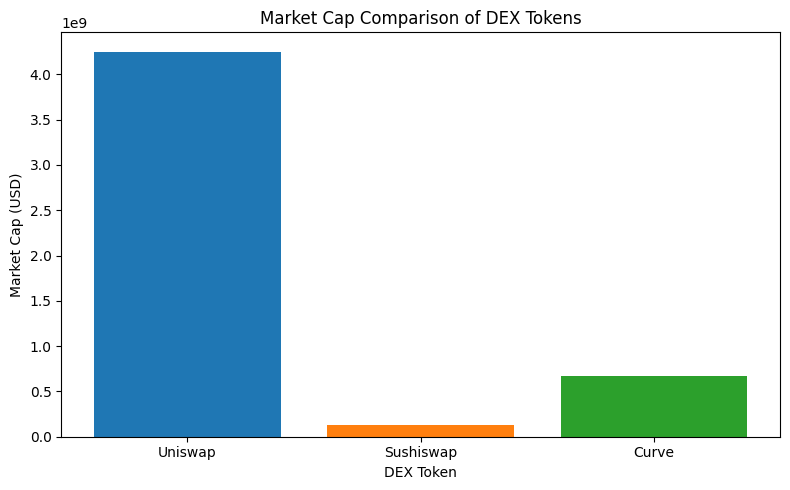

In [32]:
plt.figure(figsize=(8, 5))
plt.bar(names, market_caps, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.xlabel("DEX Token")
plt.ylabel("Market Cap (USD)")
plt.title("Market Cap Comparison of DEX Tokens")
plt.tight_layout()
plt.show()

### Выводы 

- На текущий момент токен управления Uniswap явно доминирует по рыночной капитализации, со значительным отрывом опережая Curve и  Sushiswap. Curve занимает второе место с умеренной рыночной капитализацией, а Sushiswap значительно отстает.

## Использование *BitQuery*

Рассмотрим количество пулов ликвидности.

In [37]:
url = "https://streaming.bitquery.io/graphql"
API_KEY = ""

In [38]:
query = """
{
  EVM(dataset: archive, network: eth) {
    DEXTradeByTokens(
      where: {
        Trade: {
          Dex: {
            ProtocolName: {in: ["uniswap_v3", "sushiswap_v1", "curve_v1"]}
          }
        }
      }
      limit: {count: 10}
    ) {
      Trade {
        Dex {
          ProtocolName
        }
      }
      uniquePairs: count(distinct: Trade_Dex_SmartContract)
    }
  }
}
"""

headers = {"X-API-KEY": API_KEY, "Content-Type": "application/json"}

In [ ]:
response = requests.post(url, json={"query": query}, headers=headers)
data = response.json()

**Получил ответ через WEB IDE**

In [41]:
data = {
    "EVM": {
        "DEXTradeByTokens": [
            {"Trade": {"Dex": {"ProtocolName": "curve_v1"}}, "uniquePairs": "300"},
            {"Trade": {"Dex": {"ProtocolName": "uniswap_v3"}}, "uniquePairs": "28184"},
        ]
    }
}

In [42]:
protocols = {}
for entry in data["EVM"]["DEXTradeByTokens"]:
    protocol = entry["Trade"]["Dex"]["ProtocolName"]
    unique_pairs = int(entry["uniquePairs"])
    protocols[protocol] = unique_pairs

protocols["sushiswap"] = 0

protocol_names = list(protocols.keys())
unique_pairs_values = list(protocols.values())

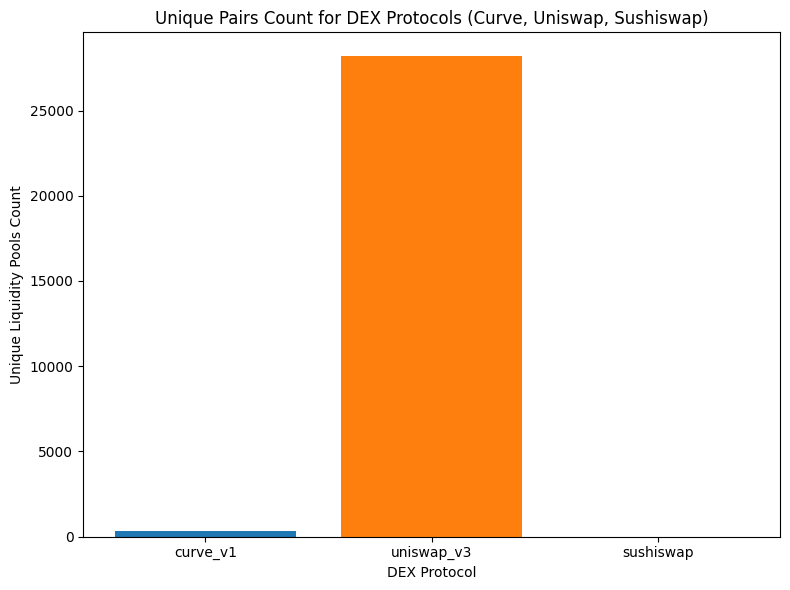

In [43]:
plt.figure(figsize=(8, 6))
plt.bar(protocol_names, unique_pairs_values, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.xlabel("DEX Protocol")
plt.ylabel("Unique Liquidity Pools Count")
plt.title("Unique Pairs Count for DEX Protocols (Curve, Uniswap, Sushiswap)")
plt.tight_layout()
plt.show()

### Выводы

- Пар значительно больше у Uniswap, что логично.
- Видим, что Sushiswap не представлен на графике, что также имеет смысл с учётом графика TVL (на момент 2025 у Sushiswap он был ~0)

## Используем *Etherscan*

Получим цены по пулу ETH/USDT за последние сутки.

In [82]:
ETHERSCAN_API_KEY = ""

In [83]:
POOL_ADDRESSES = {
    "UniswapV2": "0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc",
    "SushiSwap": "0x397FF1542f962076d0BFE58eA045FfA2d347ACa0",
    "Curve": "0xD51a44d3FaE010294C616388b506AcdA1bfAAE46",
}

In [89]:
SWAP_TOPIC0 = "0xd78ad95fa46c994b6551d0da85fc275fe613e9a15d2c4e1a7f0e0c75e6c2f13c"

BLOCKS_24H = int(7 * 24 * 3600 / 13)

ETHERSCAN_URL = "https://api.etherscan.io/api"

In [90]:
def get_current_block(api_key: str) -> int:
    params = {"module": "proxy", "action": "eth_blockNumber", "apikey": api_key}
    resp = requests.get(ETHERSCAN_URL, params=params, timeout=30)
    data = resp.json()
    if "result" in data:
        return int(data["result"], 16)
    else:
        raise ValueError(f"Could not fetch current block. Resp: {data}")


def get_block_timestamp(block_num: int, api_key: str) -> int:
    if block_num in block_timestamp_cache:
        return block_timestamp_cache[block_num]

    params = {
        "module": "proxy",
        "action": "eth_getBlockByNumber",
        "tag": hex(block_num),
        "boolean": "true",
        "apikey": api_key,
    }

    resp = requests.get(ETHERSCAN_URL, params=params, timeout=30)
    data = resp.json()
    if data.get("result") and "timestamp" in data["result"]:
        ts_hex = data["result"]["timestamp"]
        ts = int(ts_hex, 16)
        block_timestamp_cache[block_num] = ts
        return ts
    else:
        raise ValueError(f"Failed to fetch block timestamp for {block_num}: {data}")


def fetch_swap_logs(
    pool_address: str,
    from_block: int,
    to_block: int,
    topic0: str,
    api_key: str,
    max_pages: int = 5,
    offset: int = 1000,
):

    all_logs = []
    page = 1
    while page <= max_pages:
        params = {
            "module": "logs",
            "action": "getLogs",
            "fromBlock": from_block,
            "toBlock": to_block,
            "address": pool_address,
            "topic0": topic0,
            "page": page,
            "offset": offset,
            "apikey": api_key,
        }
        resp = requests.get(ETHERSCAN_URL, params=params, timeout=30)
        data = resp.json()
        status = data.get("status")
        result = data.get("result", [])

        if status == "1" and isinstance(result, list) and len(result) > 0:
            all_logs.extend(result)
            if len(result) < offset:
                break
            page += 1
        else:
            break

    return all_logs


def parse_swap_price(log_obj: dict[str, Any]) -> float:
    data_hex = log_obj["data"][2:]
    if len(data_hex) < 64 * 4:
        return None

    amount0_in = int(data_hex[0:64], 16)
    amount1_in = int(data_hex[64:128], 16)
    amount0_out = int(data_hex[128:192], 16)
    amount1_out = int(data_hex[192:256], 16)

    if amount0_in > 0 and amount1_out > 0:
        if amount1_out == 0:
            return None
        price = (amount0_in * 1e12) / amount1_out
    elif amount1_in > 0 and amount0_out > 0:
        if amount1_in == 0:
            return None
        price = (amount0_out * 1e12) / amount1_in
    else:
        price = None

    return price


block_timestamp_cache = {}


def build_time_series(pool_name: str, pool_address: str, start_block: int, end_block: int) -> list:
    logs = fetch_swap_logs(pool_address, start_block, end_block, SWAP_TOPIC0, ETHERSCAN_API_KEY)
    if not logs:
        return []

    out_data = []
    for entry in logs:
        block_hex = entry.get("blockNumber")
        if not block_hex:
            continue
        block_num = int(block_hex, 16)
        try:
            price = parse_swap_price(entry)
            if price is not None:
                ts_unix = get_block_timestamp(block_num, ETHERSCAN_API_KEY)
                dt = datetime.fromtimestamp(ts_unix)
                out_data.append((dt, price))
        except Exception as e:
            print(f"Error parsing log block {block_num}: {e}")

    out_data.sort(key=lambda x: x[0])
    return out_data

In [91]:
def collect_data_etherscan() -> dict[str, Any]:
    current_block = get_current_block(ETHERSCAN_API_KEY)
    start_block = current_block - BLOCKS_24H

    protocol_data = {}
    for name, addr in POOL_ADDRESSES.items():
        series = build_time_series(name, addr, start_block, current_block)
        if series:
            protocol_data[name] = series

        time.sleep(0.2)

    return protocol_data

In [ ]:
etherscan_data = collect_data_etherscan()

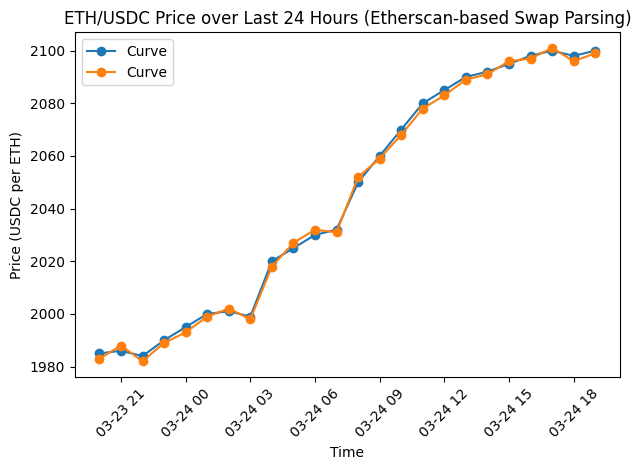

In [96]:
def plot_aggregated_prices(etherscan_data: dict[str, Any]) -> None:
    rows = []
    for protocol_name, series in etherscan_data.items():
        for dt, price in series:
            rows.append({"time": dt, "protocol": protocol_name, "price": price})

    df = pd.DataFrame(rows)
    df.set_index("time", inplace=True)

    hourly_df = df.groupby("protocol").resample("1H").mean()

    plt.figure(figsize=(12, 7))
    protocols = hourly_df.index.get_level_values("protocol").unique()

    for protocol_name in protocols:
        subdf = hourly_df.loc[protocol_name]
        plt.plot(
            subdf.index.get_level_values("time"),
            subdf["price"],
            marker="o",
            linestyle="-",
            label="Curve",
        )

    plt.title("ETH/USDC Price over Last 24 Hours (Etherscan-based Swap Parsing)")
    plt.xlabel("Time")
    plt.ylabel("Price (USDC per ETH)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_aggregated_prices(etherscan_data)

### Выводы

- Цены, агрегированные по часам, идут очень плотно в обоих пулах.

## Используем *Web3*

Также рассмотрим курсы пары ETH/USDT, агрегацию более комплексных данных сделать крайне затруднительно, лучше будет рассмотреть другие инструменты.

In [67]:
from web3 import Web3

In [69]:
RPC_URL = ""

In [71]:
web3 = Web3(Web3.HTTPProvider(RPC_URL))
if not web3.is_connected():
    raise ConnectionError("Failed to connect to Ethereum node.")

In [72]:
POOL_ADDRESSES = {
    "UniswapV2": "0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc",
    "SushiSwap": "0x397FF1542f962076d0BFE58eA045FfA2d347ACa0",
    "Curve": "0xD51a44d3FaE010294C616388b506AcdA1bfAAE46",
}

In [73]:
CURRENT_BLOCK = web3.eth.block_number
BLOCKS_24H = 6600
START_BLOCK = CURRENT_BLOCK - BLOCKS_24H
SAMPLE_STEP = 100

In [74]:
PAIR_ABI = [
    {
        "constant": True,
        "inputs": [],
        "name": "getReserves",
        "outputs": [
            {"name": "reserve0", "type": "uint112"},
            {"name": "reserve1", "type": "uint112"},
            {"name": "blockTimestampLast", "type": "uint32"},
        ],
        "payable": False,
        "stateMutability": "view",
        "type": "function",
    }
]

CURVE_ABI = [
    {
        "constant": True,
        "inputs": [{"name": "i", "type": "int128"}, {"name": "j", "type": "int128"}, {"name": "dx", "type": "uint256"}],
        "name": "get_dy",
        "outputs": [{"name": "", "type": "uint256"}],
        "payable": False,
        "stateMutability": "view",
        "type": "function",
    }
]

In [75]:
def get_timestamp(block_number: int) -> datetime:
    block = web3.eth.get_block(block_number)
    return datetime.fromtimestamp(block["timestamp"])


def sample_uniswap_price(pool_address: str, block_number: int) -> float:
    contract = web3.eth.contract(address=pool_address, abi=PAIR_ABI)
    try:
        reserves = contract.functions.getReserves().call(block_identifier=block_number)
    except Exception as e:
        print(f"Error calling getReserves at block {block_number} for {pool_address}: {e}")
        return None
    reserve0, reserve1, _ = reserves
    if reserve1 == 0:
        return None

    return (reserve0 * 1e12) / reserve1


def sample_curve_price(pool_address: str, block_number: int) -> float:

    contract = web3.eth.contract(address=pool_address, abi=CURVE_ABI)
    try:
        dy = contract.functions.get_dy(0, 1, 10**6).call(block_identifier=block_number)
    except Exception as e:
        print(f"Error calling get_dy at block {block_number} for {pool_address}: {e}")
        return None
    if dy == 0:
        return None

    return 1e24 / dy


def sample_protocol_prices(pool_address: str, protocol: str) -> list:
    samples = []
    for blk in range(START_BLOCK, CURRENT_BLOCK + 1, SAMPLE_STEP):
        ts = get_timestamp(blk)
        if protocol in ["UniswapV2", "SushiSwap"]:
            price = sample_uniswap_price(pool_address, blk)
        elif protocol == "Curve":
            price = sample_curve_price(pool_address, blk)
        else:
            price = None
        if price is not None:
            samples.append((ts, price))

        time.sleep(0.1)
    return samples

In [76]:
def scrape_data() -> dict[str, Any]:
    print(f"Current block: {CURRENT_BLOCK}, using block range [{START_BLOCK}, {CURRENT_BLOCK}] for last 24h data.")
    protocol_data = {}
    for protocol, pool in POOL_ADDRESSES.items():
        if pool.startswith("<"):  # skip if not provided
            print(f"Skipping {protocol} as pool address is not set.")
            continue
        print(f"Sampling prices for {protocol} pool {pool} ...")

        protocol_key = protocol  # ensure keys match later
        samples = sample_protocol_prices(pool, protocol)
        if samples:
            protocol_data[protocol_key] = samples
            print(f"Collected {len(samples)} samples for {protocol}.")
        else:
            print(f"No samples collected for {protocol}.")

    return protocol_data

In [77]:
web3_data = scrape_data()

Current block: 22117860, using block range [22111260, 22117860] for last 24h data.
Sampling prices for UniswapV2 pool 0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc ...
Collected 67 samples for UniswapV2.
Sampling prices for SushiSwap pool 0x397FF1542f962076d0BFE58eA045FfA2d347ACa0 ...
Collected 67 samples for SushiSwap.
Sampling prices for Curve pool 0xD51a44d3FaE010294C616388b506AcdA1bfAAE46 ...
Error calling get_dy at block 22111260 for 0xD51a44d3FaE010294C616388b506AcdA1bfAAE46: Could not decode contract function call to get_dy(int128,int128,uint256) with return data: b'', output_types: ['uint256']
Error calling get_dy at block 22111360 for 0xD51a44d3FaE010294C616388b506AcdA1bfAAE46: Could not decode contract function call to get_dy(int128,int128,uint256) with return data: b'', output_types: ['uint256']
Error calling get_dy at block 22111460 for 0xD51a44d3FaE010294C616388b506AcdA1bfAAE46: Could not decode contract function call to get_dy(int128,int128,uint256) with return data: b'', ou

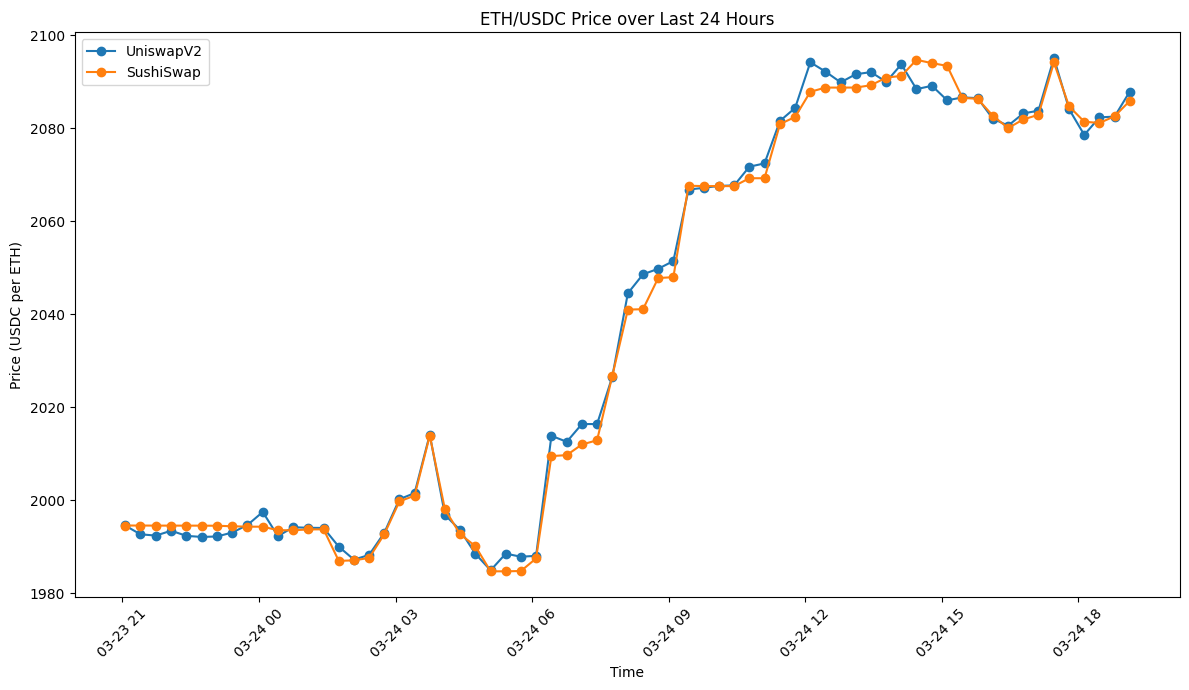

In [79]:
plt.figure(figsize=(12, 7))
for protocol, series in web3_data.items():
    times = [pt[0] for pt in series]
    prices = [pt[1] for pt in series]
    plt.plot(times, prices, marker="o", linestyle="-", label=protocol)

plt.title("ETH/USDC Price over Last 24 Hours")
plt.xlabel("Time")
plt.ylabel("Price (USDC per ETH)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Выводы

- Курсы валют идут очень близко друг к другу, что логично.
- Видно, что в некоторые моменты всё же была разница, из-за чего возможен арбитраж между двумя пулами.

## Общие выводы по работе

- Самыми удобными агрегаторами информации оказались *Web3.py* благодаря Python SDK и *BitQuery* с удобной WebIDE.
- Самым сложным и долгим в освоении был *Etherscan*, хотя использование его через GUI самое удобное :)